In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pprint import pprint
import time

import inputools.Trajectory as it
from tools.evolutions import load_best_individual
import src.models as mm
from src.models import logger
import src.visualizations as mv

from tools.utils import clf, tqdm_enumerate, save_image

%load_ext autoreload
%autoreload 2

plt.style.use('classic')
logger()

2024-02-16 17:38:22 | 


This notebook is about the study of active navigation by exploiting a formed place cell layer.

## hard-coded PC layer 
---

#### Trajectory

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:00<00:00, 127152.14it/s]


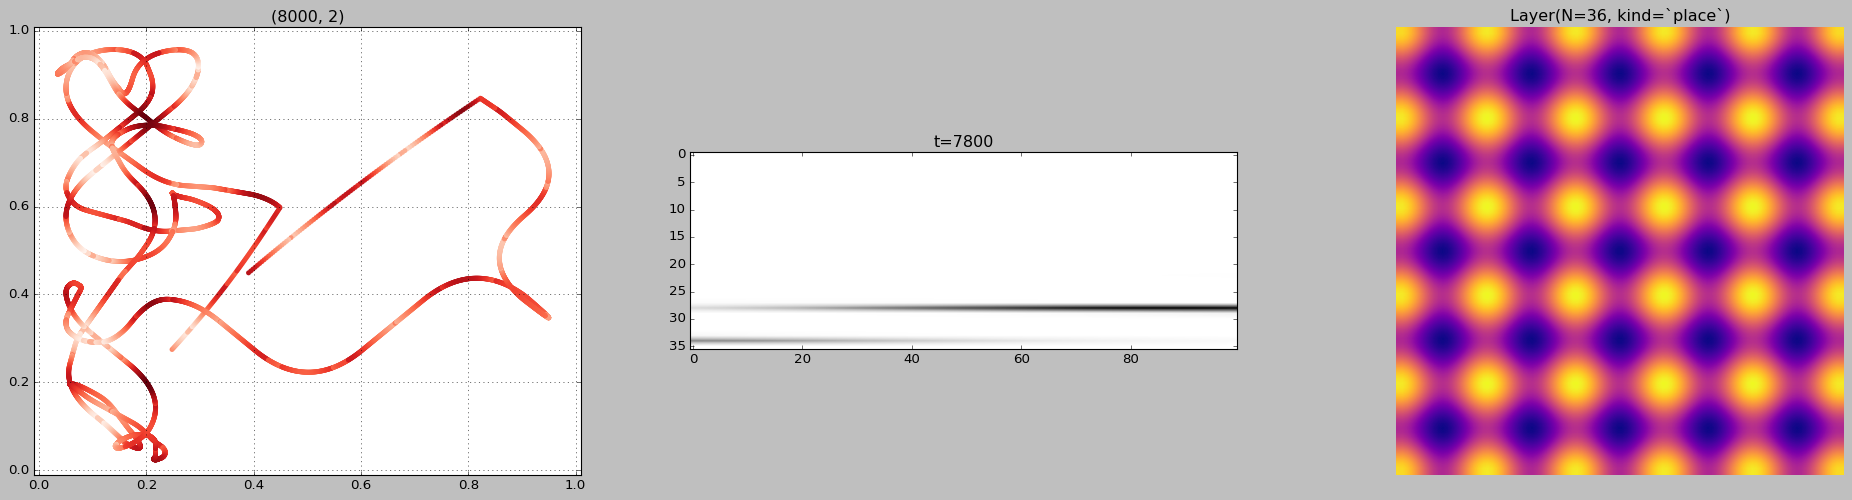

In [24]:
# input
duration = 8
speed = 1
dt = 1e-4
Nj = 6**2
sigma = 0.01

trajectory = it.make_trajectory(duration=duration, dt=dt, speed=[speed, speed], 
                                  prob_turn=0.005, k_average=200, dim=2)

#layer = it.HDLayer(N=5**2, sigma=0.01)
layer = it.PlaceLayer(N=Nj, sigma=sigma)

A = layer.parse_trajectory(trajectory=trajectory)

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 7))
z = np.zeros(len(A))
for i in range(len(A[0])):
    z += np.where(A[:, i] > 0.1, A[:, i], 0)

ax1.scatter(trajectory[:, 0], trajectory[:, 1], c=z, s=20, cmap='Reds',
           edgecolors='black', linewidths=0)
ax1.set_ylim((-0.01, 1.01))
ax1.set_xlim((-0.01, 1.01))
ax1.grid()
ax1.set_title(trajectory.shape)

for t in range(0, len(A)-100, 100):
    ax2.imshow(A[t:t+100, :].T, cmap='Greys')
    ax2.set_title(f"{t=}")
    
layer.plot(size=100, kind='imshow', sigmoid_beta=0.01, sigmoid_alpha=0., ax=ax3)